In [1]:
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv('train_data.csv')
df

,Sentence,Emotion
0,کی گفته مرد گریه نمیکنه!؟!؟ سیلم امشب سیل #اصفهان,SAD
1,عکسی که چند روز پیش گذاشته بودم این فیلم الانش...,OTHER
2,تنهاییم شبیه تنهاییه ظهرای بچگیم شده وقتی که ه...,SAD
3,خوبه تمام قسمت‌های گوشی رو محافظت می‌کنه,HAPPY
4,این خاک مال مردمان است نه حاکمان #ایران #مهسا_...,ANGRY
...,...,...
4919,من از بو و ماندگاریش راضی بودم ، قیمتش هم‌ مناسبه,HAPPY
4920,گاز نداریم آب نداریم برق نداریم نت نداریم پول ...,SAD
4921,یکی بهم گفت برنو چرا عاشق نمیشی گفتم ما پول عا...,SAD
4922,زیادی داریم به قضیه ی گاز میپردازیم فقط فراخوا...,OTHER


In [3]:
df.shape

(4924, 2)

In [4]:
df.describe()

,Sentence,Emotion
count,4924,4924
unique,4922,5
top,#NAME?,HAPPY
freq,3,1462


In [5]:
df.isnull().sum()

Sentence    0
Emotion     0
dtype: int64

In [6]:
df.duplicated().sum()

1

In [7]:
df.drop_duplicates()

,Sentence,Emotion
0,کی گفته مرد گریه نمیکنه!؟!؟ سیلم امشب سیل #اصفهان,SAD
1,عکسی که چند روز پیش گذاشته بودم این فیلم الانش...,OTHER
2,تنهاییم شبیه تنهاییه ظهرای بچگیم شده وقتی که ه...,SAD
3,خوبه تمام قسمت‌های گوشی رو محافظت می‌کنه,HAPPY
4,این خاک مال مردمان است نه حاکمان #ایران #مهسا_...,ANGRY
...,...,...
4919,من از بو و ماندگاریش راضی بودم ، قیمتش هم‌ مناسبه,HAPPY
4920,گاز نداریم آب نداریم برق نداریم نت نداریم پول ...,SAD
4921,یکی بهم گفت برنو چرا عاشق نمیشی گفتم ما پول عا...,SAD
4922,زیادی داریم به قضیه ی گاز میپردازیم فقط فراخوا...,OTHER


<AxesSubplot: >

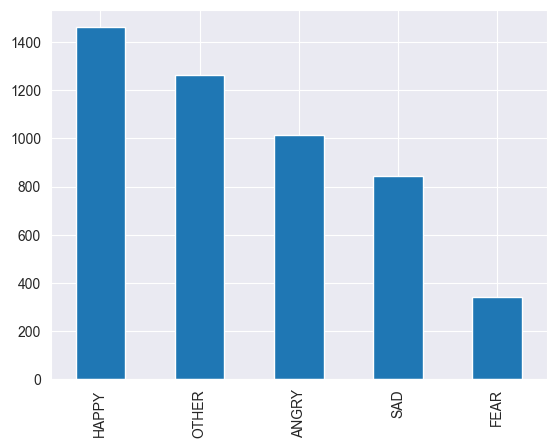

In [8]:
plot_df = df.Emotion.value_counts()
plot_df.plot(kind="bar")

From this plot we can see that our data is not balance and label of happy is more frequent than other labels and label of fear is the least frequent.

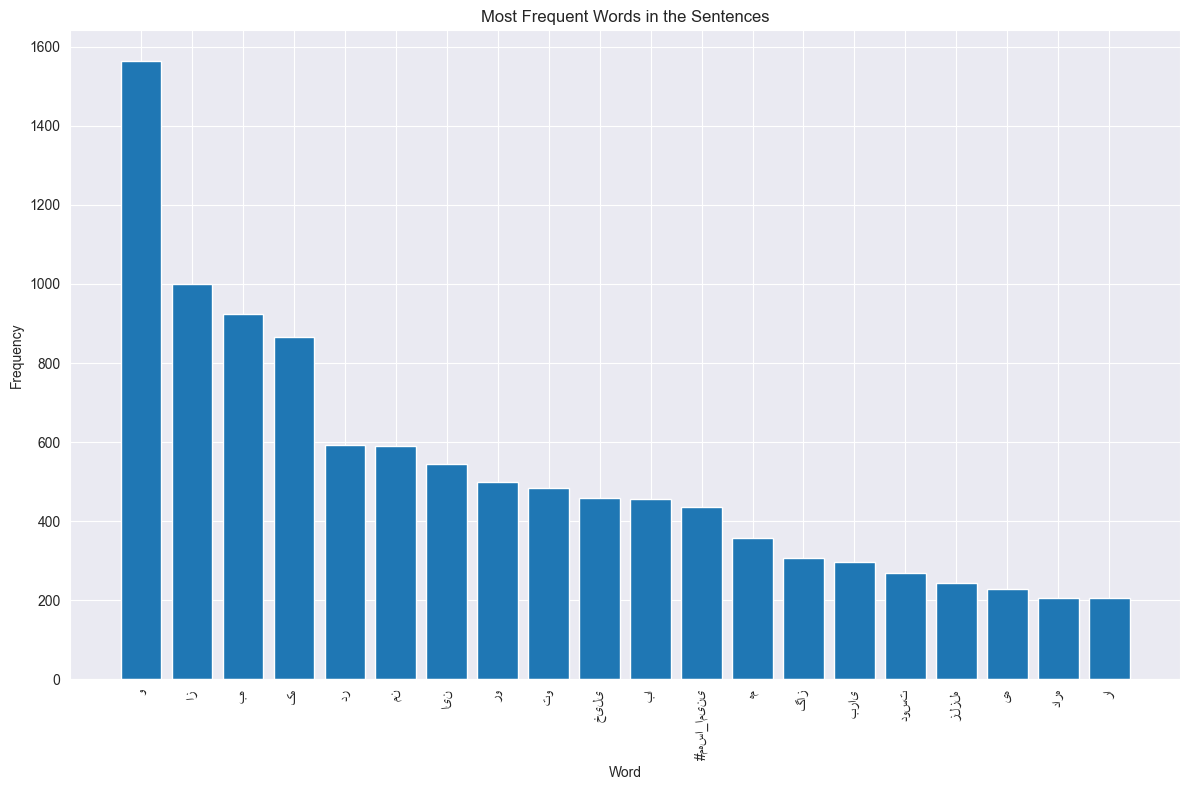

In [9]:
from collections import Counter
import matplotlib.pyplot as plt

all_words = ' '.join(df['Sentence']).lower().split()

# Count the frequency of each word
word_counts = Counter(all_words)

# Get the top 20 most frequent words
top_words = word_counts.most_common(20)

# Create the bar plot
plt.figure(figsize=(12, 8))
plt.bar([word[0] for word in top_words], [word[1] for word in top_words])
plt.xticks(rotation=90)
plt.title('Most Frequent Words in the Sentences')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

As we can see our conjunction joins words are the most frequent words in our dataset and we have to handle that with normalizer.

Sentence Length Statistics:
count    4924.000000
mean       11.114541
std         3.967709
min         1.000000
25%         8.000000
50%        10.000000
75%        14.000000
max        23.000000
Name: sentence_length, dtype: float64


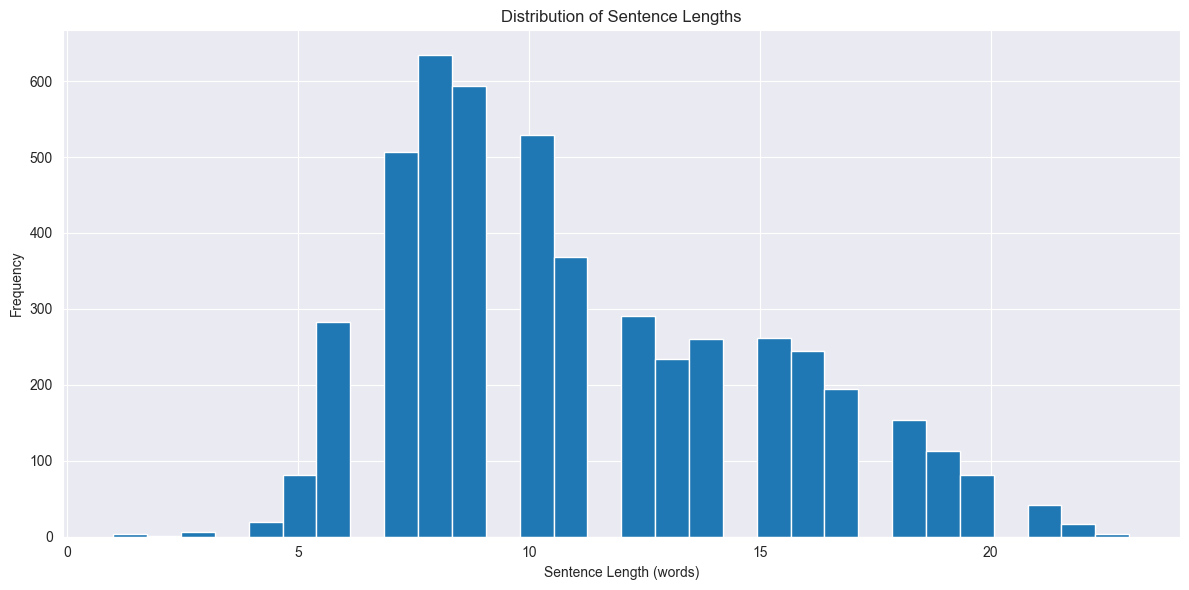

In [10]:
df['sentence_length'] = df['Sentence'].str.split().str.len()

# Descriptive statistics
print('Sentence Length Statistics:')
print(df['sentence_length'].describe())

# Visualize the distribution
plt.figure(figsize=(12, 6))
plt.hist(df['sentence_length'], bins=30)
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Sentence Length (words)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

The distribution of the length show us that most of our sentences has the length between 6-15 words.

# Preprocessing

At first we need to check the variety of the characters that is used in our data.

In [11]:
uniqueChars = set(''.join(df['Sentence']))
print(len(uniqueChars))
print(uniqueChars)

210
{'»', 'V', 'ت', 'ج', 'q', 'U', '☠', '|', 'N', '\u2069', 'أ', '۷', 'M', 'چ', 'ژ', 'ᴛ', 'm', 'd', '♥', '✨', 'ّ', 'ل', '⚘', '١', '۰', 'ہ', '6', '4', 'خ', 'ء', '۶', '☝', '¹', ']', '0', '✅', '9', '♂', 'ي', 'پ', 'Y', 'a', 'n', 'ـ', '☄', 'َ', 'L', 'C', '*', 'g', '☹', '\u2067', 'ᴏ', '}', '❤', 'ᴇ', 'p', '⁉', '\u200c', 'W', '‐', 'ط', '\u2066', 'ح', 'o', '?', 'h', 'ش', '۳', '”', 'I', 'ك', '8', 'ھ', ';', '.', 'l', 'f', '«', 'ؤ', 'b', '۱', 'E', 'ذ', '✌', '+', '۴', 'k', '۔', ' ', '۸', 'ظ', '~', 'c', '️', '=', 'z', 'س', '♀', 'x', '٦', '[', 'ً', 'ʏ', 'گ', '؛', '٪', 'e', '۵', 'ن', 'ف', '✋', ',', 'م', '’', 'ۀ', 'ص', 's', '3', '٠', 'ک', 'F', ':', 'غ', 'G', '٢', '_', 'ە', '-', 'B', '✍', ')', 'i', 'v', 'O', 'w', 'P', 'ض', 'ے', 'u', '°', 'آ', '/', 'Q', '\u200d', 'ɴ', '²', 't', 'A', 'ة', '‘', '⃟', 'r', 'T', 'ِ', 'ع', '۲', 'J', '%', 'j', '؟', 'y', '☺', '⭕', '⚽', '⊰', '،', '۹', 'ٔ', 'ټ', '5', 'D', '1', 'H', 'د', '٣', 'ق', 'ه', 'و', 'S', '&', 'ب', '•', 'ى', '“', 'ا', '…', 'ْ', '٬', '#', '⭐', '^', 'ث', '٫', 

As we can see there is four important problem.
1. There is five type of 'ی' that can be a real problem because there is a unique unicode for each one.
2. There are persian and latin numbers together that can be a problem.
3. There are capital and small letter together.
4. There are some emojy that would make us trouble

So we have to handle these problem to clean our data and make that more usable and reliable.

In here we will define two function:
1. __normalize_persian__: This function will replace persian numbers with latin and handle five kind of 'ی' and make them one.
2. __preprocess_text__: This function will apply normalize_persian on our data and also make all of our latin letters lower case.

In [12]:
def normalize_persian(text):
    # Define a function to normalize Persian characters and numbers
    persian_digits = '۰۱۲۳۴۵۶۷۸۹٦١٢٣'
    english_digits = '01234567896123'
    yeh_characters = ['ی', 'ي', 'ے', 'ئ', 'ى']

    text = text.translate(str.maketrans(persian_digits, english_digits))
    for char in yeh_characters:
        text = text.replace(char, 'ی')

    return text

In [13]:
def preprocess_text(text):
    # Normalize Persian characters
    text = normalize_persian(text)

    # Convert to lowercase
    text = text.lower()

    # Add more preprocessing steps as needed

    return text

In [14]:
df['Sentence'] = df['Sentence'].apply(preprocess_text)
uniqueChars = set(''.join(df['Sentence']))
print(len(uniqueChars))
print(uniqueChars)

167
{'»', 'ت', 'ج', 'q', '☠', '|', '\u2069', 'أ', 'چ', 'ژ', 'ᴛ', 'm', 'd', '♥', '✨', 'ّ', 'ل', '⚘', 'ہ', '6', '4', 'خ', 'ء', '☝', '¹', ']', '0', '✅', '9', '♂', 'پ', 'n', 'a', 'ـ', '☄', 'َ', '*', 'g', '☹', '\u2067', 'ᴏ', '}', '❤', 'ᴇ', 'p', '⁉', '\u200c', '‐', 'ط', '\u2066', 'ح', 'o', '?', 'h', 'ش', '”', '8', 'ك', 'ھ', ';', '.', 'l', 'f', '«', 'ؤ', 'b', 'ذ', '✌', '+', 'k', '۔', '~', ' ', 'ظ', 'c', '️', '=', 'z', 'س', '♀', 'x', 'ʏ', '[', 'ً', 'گ', '؛', '٪', 'e', 'ن', 'ف', '✋', ',', 'م', '’', 'ۀ', 'ص', 's', '3', '٠', 'ک', ':', 'غ', '_', 'ە', '-', '✍', ')', 'i', 'v', 'w', 'ض', 'u', '°', 'آ', '/', '\u200d', 'ɴ', '²', 't', 'ة', '‘', '⃟', 'r', 'ِ', 'ع', '%', 'j', '؟', 'y', '☺', '⭕', '⚽', '⊰', '،', 'ٔ', 'ټ', '5', '1', 'د', 'ق', 'ه', 'و', '&', '•', 'ب', '“', 'ا', '…', 'ْ', '٬', '#', '⭐', '^', 'ث', '٫', '\n', '☘', '❄', '!', 'ز', 'ُ', 'ر', '(', '2', '⛓', '7', 'ی'}


Now we can see that we handle the numbers and the letters.

Now we will use hazm library to cope with data:
1. Normalization: Converts text to a standard form, such as removing diacritics, correcting spacing, etc.
2. Tokenization: Splits text into sentences and words.
3. Lemmatization: Reduces words to their base forms.

In [15]:
import hazm
def text_normalizer(data):
    normalizer = hazm.Normalizer()
    data['Sentence'] = data['Sentence'].apply(normalizer.normalize)
    return data

def word_tokenizer(data):
    data['Sentence'] = data['Sentence'].apply(hazm.word_tokenize)
    return data

def text_lemmatizer(data):
    lemmatizer = hazm.Lemmatizer()
    data['Sentence'] = data['Sentence'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x]))
    return data

In [16]:
df = text_normalizer(df)
df = word_tokenizer(df)
df = text_lemmatizer(df)
df.head()

,Sentence,Emotion,sentence_length
0,کی گفته مرد گریه نمیکنه !؟!؟ سیل امشب سیل #اصفهان,SAD,9
1,عکس که چند روز پیش گذاشت#گذار این فیلم الانشه ...,OTHER,17
2,تن شبیه تنهاییه ظهرای بچگیم شده وقتی‌که همه می...,SAD,20
3,خوبه تمام قسمت گوشید#گوش رو محافظت می‌کنه,HAPPY,7
4,این خاک‌مال مردمان است نه حاکمان #ایران #مهسا_...,ANGRY,9


In [17]:
uniqueChars = set(''.join(df['Sentence']))
print(len(uniqueChars))
print(uniqueChars)

148
{'»', 'ت', 'ج', 'q', '☠', '|', '\u2069', 'أ', '۷', 'چ', 'ژ', 'ᴛ', 'm', 'd', '♥', '✨', 'ل', '⚘', '۰', 'خ', 'ء', '۶', '☝', '¹', ']', '✅', '♂', 'پ', 'n', 'a', '☄', '*', 'g', '☹', '\u2067', 'ᴏ', '}', '❤', 'ᴇ', 'p', '⁉', '\u200c', '‐', 'ط', '\u2066', 'ح', 'o', '?', 'h', 'ش', '۳', ';', '.', 'l', 'f', '«', 'ؤ', 'b', '۱', 'ذ', '✌', '+', '۴', 'k', '~', ' ', '۸', 'ظ', 'c', '️', '=', 'z', 'س', '♀', 'x', 'ʏ', '[', 'گ', '؛', '٪', 'e', '۵', 'ن', 'ف', '✋', ',', 'م', '’', 'ص', 's', 'ک', ':', 'غ', '_', '-', '✍', ')', 'i', 'v', 'w', 'ض', 'u', '°', 'آ', '/', '\u200d', 'ɴ', '²', 't', 'ة', '‘', '⃟', 'r', 'ع', '۲', 'j', '؟', 'y', '☺', '⭕', '⚽', '⊰', '،', '۹', '"', 'د', 'ق', 'ه', 'و', '&', '•', 'ب', 'ا', '…', '٬', '#', '⭐', '^', 'ث', '٫', '☘', '❄', '!', 'ز', 'ر', '(', '⛓', 'ی'}


Hazm library helps us to normalize and tokenize and lemmatize the sentences.
Normalizing text in the context of natural language processing (NLP) refers to the process of transforming text into a standardized format or representation. This typically involves tasks such as converting all text to lowercase, removing stop words (common words that do not carry significant meaning), and other similar operations. After normalizing the text, we used a word tokenizer to separate the words into individual tokens. This is an important step for many NLP tasks, as it allows us to work with the text at the word level. The next step was lemmatization, which uses linguistic knowledge to convert words to their base or dictionary form. This helps to reduce the dimensionality of the text and can improve the performance of various NLP models. All above parts was doing these important steps.

Then we need to remove the english words because we are working with the persian language and those english words will make confusion for our model.

In [18]:
def containsEnglishLetters(word):
    for char in word:
        if char.isalpha() and char.isascii():
            return True
    return False

def removeEnglishWords(dataset):
    for i, element in enumerate(dataset):
        words = element.split()
        cleanedWords = []
        for word in words:
            if not containsEnglishLetters(word):
                cleanedWords.append(word)
        cleanedText = " ".join(cleanedWords)
        dataset[i] = cleanedText
    return dataset

In [19]:
df['Sentence'] = removeEnglishWords(df['Sentence'])
uniqueChars = set(''.join(df['Sentence']))
print(len(uniqueChars))
print(uniqueChars)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21364\1746826762.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i] = cleanedText


115
{'»', 'ت', 'ج', '☠', '|', '\u2069', 'أ', '۷', 'چ', 'ژ', '♥', '✨', 'ل', '⚘', '۰', 'خ', 'ء', '۶', '☝', ']', '✅', '♂', 'پ', '☄', '*', '☹', '\u2067', '}', '❤', '⁉', '\u200c', '‐', 'ط', '\u2066', 'ح', '?', 'ش', '۳', ';', '.', '«', 'ؤ', '۱', 'ذ', '✌', '+', '۴', '~', ' ', '۸', 'ظ', '️', '=', 'س', '♀', '[', 'گ', '؛', '٪', '۵', 'ن', 'ف', '✋', ',', 'م', '’', 'ص', 'ک', ':', 'غ', '_', '-', '✍', ')', 'ض', '°', 'آ', '/', '\u200d', '²', 'ة', '‘', '⃟', 'ع', '۲', '؟', '☺', '⭕', '⚽', '⊰', '،', '۹', '"', 'د', 'ق', 'ه', 'و', '•', 'ب', 'ا', '…', '٬', '#', '⭐', '^', 'ث', '٫', '☘', '❄', '!', 'ز', 'ر', '(', '⛓', 'ی'}


This is time to handle the emojy.

In [20]:
import pandas as pd
import re

def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def clean_dataset(dataset):
    """
    Cleans a dataset by removing emojis from all text columns.

    Parameters:
    dataset (pandas.DataFrame): The input dataset to be cleaned.

    Returns:
    pandas.DataFrame: The cleaned dataset with emojis removed.
    """
    # Create a copy of the dataset to avoid modifying the original
    cleaned_dataset = dataset.copy()

    # Iterate through all text columns and remove emojis
    for column in dataset.select_dtypes(include=['object']):
        cleaned_dataset[column] = dataset[column].apply(remove_emojis)

    return cleaned_dataset

In [21]:
df = clean_dataset(df)
uniqueChars = set(''.join(df['Sentence']))
print(len(uniqueChars))
print(uniqueChars)

93
{'»', 'ت', 'ج', '|', '\u2069', 'أ', '۷', 'چ', 'ژ', 'ل', '۰', 'خ', 'ء', '۶', ']', 'پ', '*', '\u2067', '}', '⁉', '\u200c', '‐', 'ط', '\u2066', 'ح', '?', 'ش', '۳', ';', '.', '«', 'ؤ', '۱', 'ذ', '+', '~', '۴', ' ', '۸', 'ظ', '=', 'س', '[', 'گ', '؛', '٪', '۵', 'ن', 'ف', ',', 'م', '’', 'ص', 'ک', ':', 'غ', '_', '-', ')', 'ض', '°', 'آ', '/', '\u200d', '²', 'ة', '‘', '⃟', 'ع', '۲', '؟', '⊰', '،', '۹', '"', 'د', 'ق', 'ه', 'و', '•', 'ب', 'ا', '…', '٬', '#', '^', 'ث', '٫', '!', 'ز', 'ر', '(', 'ی'}


Now our main work with data cleaning is ending.
Now we will split our data and encode the target variable.

In [22]:
from sklearn.model_selection import train_test_split
encoder = OrdinalEncoder()
df['Emotion'] = encoder.fit_transform(df[['Emotion']])
train_data, test_data = train_test_split(df, random_state=42, test_size=0.2)

In [23]:
train_x = pd.DataFrame(train_data['Sentence'], columns=['Sentence'], index=train_data.index)
train_y = train_data['Emotion']

test_x = pd.DataFrame(test_data['Sentence'], columns=['Sentence'], index=test_data.index)
test_y = test_data['Emotion']

As it is clear, it is impossible to train a machine learning model on data that consists solely of text and words. This is because models require numerical inputs that they can interpret and process, rather than raw text data. Therefore, we need to convert the textual data into numerical representations that the model can understand.
One common technique for this is called TF-IDF (Term Frequency-Inverse Document Frequency). TF-IDF is a method that assigns a numerical value to each word in a text corpus, based on the word's frequency within a document and across the entire corpus.


Sure, here's the TF-IDF (Term Frequency-Inverse Document Frequency) formulation in Markdown format:

$$
\text{TF-IDF}(t, d) = \text{TF}(t, d) \times \text{IDF}(t)
$$

where:

$$
\text{TF}(t, d) = \frac{\text{Number of times term } t \text{ appears in document } d}{\text{Total number of terms in document } d}
$$

and

$$
\text{IDF}(t) = \log\left(\frac{\text{Total number of documents}}{\text{Number of documents with term } t \text{ in it}}\right)
$$

In [24]:
vectorizer = TfidfVectorizer()
vector = vectorizer.fit_transform(train_x['Sentence'])
vectorized_x_train = pd.DataFrame(vector.toarray(), columns=vectorizer.get_feature_names_out(), index=train_data.index)

vector2 = vectorizer.transform(test_x['Sentence'])
vectorized_x_test = pd.DataFrame(vector2.toarray(), columns=vectorizer.get_feature_names_out(), index=test_data.index)
print(vectorized_x_train.shape)
print(vectorized_x_test.shape)

(3939, 7559)
(985, 7559)


As we know our data is imbalance so, we have to balance that. To address this imbalance, the SMOTE (Synthetic Minority Over-sampling Technique) method from the scikit-learn (sklearn) library was used as the last step in the feature engineering process. SMOTE is a popular oversampling technique used to handle imbalanced data. It generates synthetic samples of the minority class, effectively increasing the number of samples in the underrepresented class. This helps to balance the dataset, reducing the bias towards the majority class and improving the performance of the machine learning model.

In [25]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Oversampling using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(vectorized_x_train, train_y)

# Undersampling using Random Undersampler
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_resampled, y_train_resampled)

# Model Training

In this section we will try to find the best parameters for each model and also try to find the best model by using cross validation.

For this object, for each model we will define a param_grids that is our parameter that we want to find the optimum between them.
After that by using CV we will find the best parameters.
Then we will train a model and estimate the error by CV.

In here we will define a function that by using train and test set and model and parameters for grid search, it will give us the best parameters by CV and also evaluate the performance of the by CV and also by test set and show us confusion matrix too.

In [26]:
from sklearn.metrics import f1_score, precision_score, accuracy_score, roc_curve, ConfusionMatrixDisplay, confusion_matrix, auc
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import matplotlib.pyplot as plt

def model_train_test_evaluating(x_train, y_train, x_test, y_test, model, param_grid):
    grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='f1_macro')
    grid_search.fit(x_train, y_train)
    classifier = grid_search.best_estimator_

    y_train_pred = classifier.predict(x_train)
    y_test_pred = classifier.predict(x_test)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    f1_train = f1_score(y_train, y_train_pred, average='macro')
    if not y_test.isnull().all():
        test_accuracy = accuracy_score(y_test, y_test_pred)
        f1_test = f1_score(y_test, y_test_pred, average='macro')

    print('Cross validation results:')
    print(f"Best parameters between {param_grid} are : {grid_search.best_params_}")
    print(f"Best score with these parameters is : {grid_search.best_score_:.4f}")

    print('train data result:')
    print('Accuracy: ', end='')
    print(train_accuracy)
    print('F1_score: ', end='')
    print(f1_train)

    cm = confusion_matrix(y_train, y_train_pred)
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    if not y_test.isnull().all():
        print('test_data report:')
        print('Acuuracy: ', end='')
        print(test_accuracy)
        print('F1_score: ', end='')
        print(f1_test)

        cm = confusion_matrix(y_test, y_test_pred)
        # Plot the confusion matrix
        plt.figure(figsize=(8, 6))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()

    return y_test_pred

### Decision Tree
First of all we will work with Decision tree and for that we will check criterion and max depth.

In [27]:
param_grids = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [40, 50, 60],
}

Cross validation results:
Best parameters between {'criterion': ['gini', 'entropy'], 'max_depth': [40, 50, 60]} are : {'criterion': 'gini', 'max_depth': 60}
Best score with these parameters is : 0.6216
train data result:
Accuracy: 0.8596306068601584
F1_score: 0.868688052927674


<Figure size 800x600 with 0 Axes>

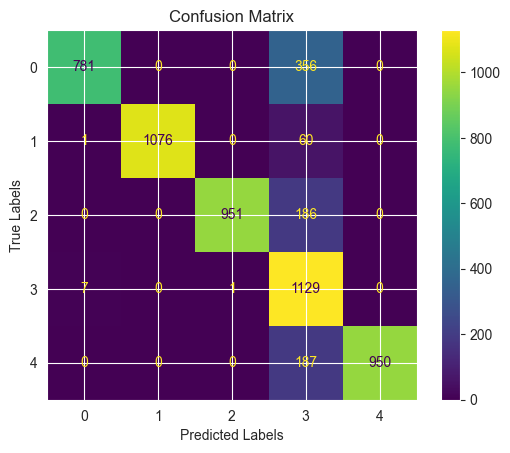

test_data report:
Acuuracy: 0.5015228426395939
F1_score: 0.4672690471284315


<Figure size 800x600 with 0 Axes>

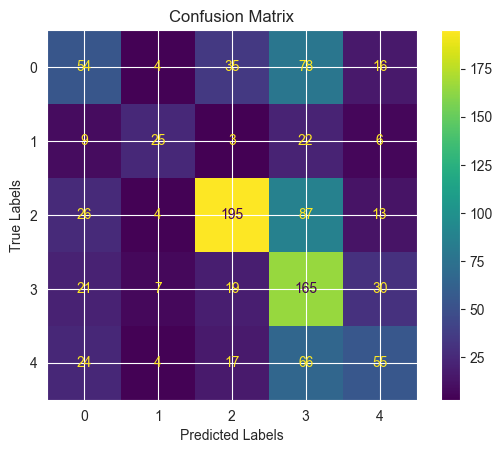

array([3., 3., 2., 0., 1., 3., 2., 3., 2., 3., 2., 2., 2., 3., 2., 3., 4.,
       4., 3., 3., 0., 4., 2., 4., 0., 2., 3., 0., 4., 3., 3., 0., 2., 0.,
       3., 3., 2., 2., 4., 2., 3., 3., 3., 3., 2., 0., 2., 0., 3., 2., 3.,
       2., 2., 3., 3., 3., 2., 3., 0., 0., 3., 3., 3., 3., 3., 3., 2., 2.,
       3., 3., 0., 2., 3., 0., 4., 3., 3., 2., 4., 2., 3., 3., 3., 2., 2.,
       3., 3., 2., 4., 1., 3., 2., 1., 2., 0., 4., 3., 3., 3., 2., 3., 3.,
       2., 3., 0., 4., 1., 2., 3., 0., 2., 3., 3., 3., 0., 0., 2., 0., 3.,
       0., 3., 3., 3., 2., 4., 3., 2., 3., 3., 2., 2., 4., 0., 0., 2., 4.,
       3., 0., 3., 3., 0., 3., 4., 2., 3., 3., 0., 0., 1., 3., 3., 3., 1.,
       1., 0., 2., 2., 3., 4., 3., 3., 1., 3., 3., 2., 3., 3., 2., 1., 3.,
       3., 3., 3., 3., 3., 2., 3., 3., 3., 0., 3., 3., 0., 2., 0., 3., 2.,
       3., 4., 3., 4., 2., 2., 3., 2., 3., 4., 4., 2., 0., 0., 3., 4., 4.,
       0., 3., 3., 3., 3., 3., 3., 3., 2., 2., 2., 3., 3., 2., 2., 1., 3.,
       2., 2., 1., 2., 2.

In [28]:
model_train_test_evaluating(X_train_resampled, y_train_resampled, vectorized_x_test, test_y, DecisionTreeClassifier(), param_grids)

As we can see the Decision tree is not very good for this case and its accuracy on test is about 50 percent.

### Random Forest
We will continue with random forest model and we will check number of estimators and max depth for that.

In [29]:
param_grids = {
    'n_estimators': [50, 100, 150],
    'max_depth': [50, 60, 70],
}

Cross validation results:
Best parameters between {'n_estimators': [50, 100, 150], 'max_depth': [50, 60, 70]} are : {'max_depth': 70, 'n_estimators': 100}
Best score with these parameters is : 0.7364
train data result:
Accuracy: 0.9759014951627089
F1_score: 0.9762123960917947


<Figure size 800x600 with 0 Axes>

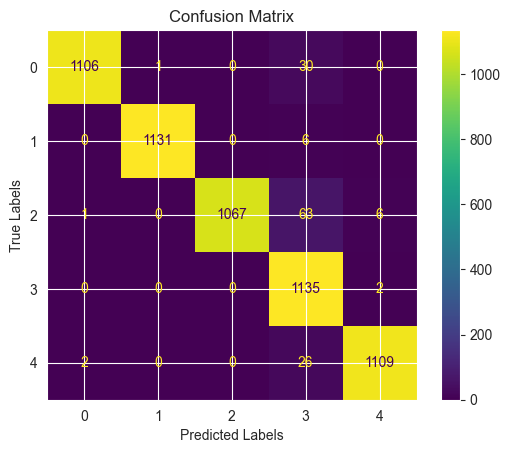

test_data report:
Acuuracy: 0.5807106598984771
F1_score: 0.5499079538119094


<Figure size 800x600 with 0 Axes>

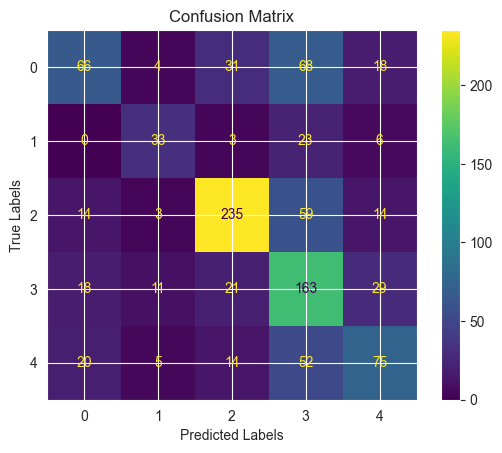

array([3., 0., 2., 4., 1., 4., 2., 2., 3., 3., 2., 2., 4., 3., 2., 3., 4.,
       4., 3., 3., 1., 4., 2., 4., 0., 2., 3., 2., 4., 0., 3., 2., 2., 3.,
       4., 3., 0., 2., 4., 2., 2., 3., 0., 4., 2., 0., 2., 0., 3., 2., 3.,
       2., 4., 3., 3., 3., 2., 0., 0., 0., 3., 1., 3., 3., 3., 1., 4., 2.,
       3., 3., 0., 2., 2., 3., 2., 3., 2., 2., 4., 4., 3., 3., 4., 2., 0.,
       3., 3., 2., 4., 1., 3., 2., 0., 2., 3., 4., 4., 3., 3., 2., 3., 3.,
       2., 0., 3., 4., 2., 3., 3., 0., 2., 3., 3., 3., 2., 3., 0., 2., 3.,
       4., 2., 3., 3., 2., 4., 3., 2., 3., 3., 2., 2., 3., 3., 3., 2., 4.,
       3., 2., 3., 2., 0., 4., 3., 3., 3., 3., 0., 3., 1., 2., 0., 3., 1.,
       1., 0., 2., 2., 3., 0., 2., 2., 1., 3., 4., 2., 1., 3., 2., 3., 3.,
       3., 0., 2., 3., 3., 3., 4., 0., 3., 3., 3., 3., 4., 2., 0., 3., 2.,
       3., 4., 3., 3., 2., 2., 2., 2., 2., 4., 4., 0., 3., 2., 2., 3., 4.,
       0., 3., 3., 3., 3., 0., 2., 2., 2., 2., 2., 3., 3., 2., 2., 3., 2.,
       2., 2., 3., 2., 2.

In [30]:
model_train_test_evaluating(X_train_resampled, y_train_resampled, vectorized_x_test, test_y, RandomForestClassifier(), param_grids)

Random forest is better than Decision tree and its accuracy is 58 percent on test data and show that random forest is better.

### Extra Trees
Next two cell will check number of estimators and criterion for extra trees model.

In [31]:
param_grids = {
    'n_estimators': [50, 60, 70],
    'criterion': ['gini', 'entropy'],
}

Cross validation results:
Best parameters between {'n_estimators': [50, 60, 70], 'criterion': ['gini', 'entropy']} are : {'criterion': 'gini', 'n_estimators': 70}
Best score with these parameters is : 0.7726
train data result:
Accuracy: 0.998768689533861
F1_score: 0.9987689208460125


<Figure size 800x600 with 0 Axes>

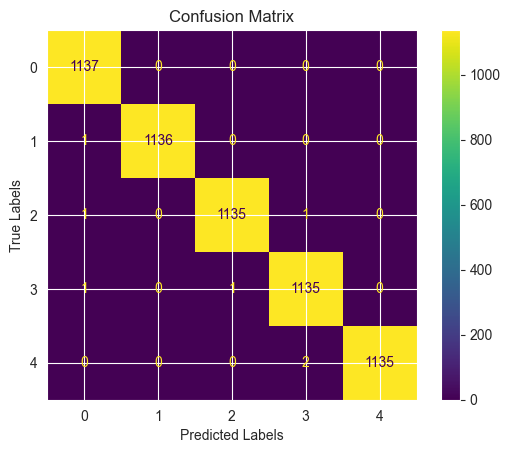

test_data report:
Acuuracy: 0.6020304568527919
F1_score: 0.570714674437599


<Figure size 800x600 with 0 Axes>

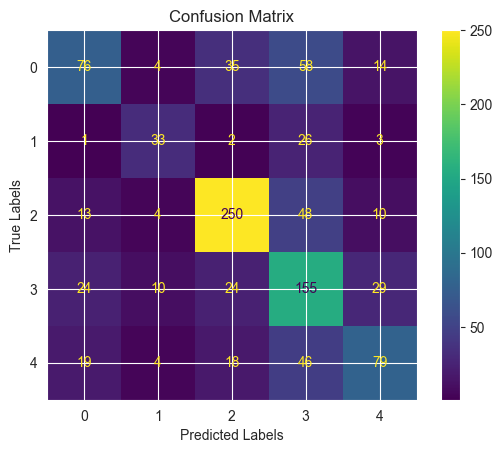

array([3., 0., 2., 4., 1., 3., 2., 2., 3., 3., 2., 0., 4., 3., 2., 3., 4.,
       4., 3., 3., 1., 4., 2., 2., 0., 2., 3., 2., 4., 0., 3., 2., 2., 3.,
       4., 3., 2., 2., 3., 2., 2., 0., 0., 4., 2., 0., 2., 0., 3., 2., 3.,
       2., 3., 3., 3., 3., 2., 0., 0., 0., 3., 1., 3., 3., 3., 1., 4., 2.,
       3., 0., 0., 2., 2., 4., 2., 3., 2., 2., 4., 4., 3., 3., 4., 2., 2.,
       3., 3., 2., 4., 1., 3., 3., 0., 2., 3., 2., 4., 3., 0., 2., 3., 3.,
       2., 4., 3., 4., 1., 2., 3., 0., 2., 3., 2., 0., 2., 3., 0., 2., 3.,
       4., 2., 2., 2., 2., 4., 4., 2., 3., 1., 2., 2., 3., 3., 3., 2., 4.,
       3., 2., 3., 2., 0., 0., 4., 3., 3., 3., 0., 0., 1., 2., 0., 3., 3.,
       1., 0., 2., 2., 0., 4., 2., 2., 1., 3., 4., 2., 1., 3., 2., 2., 2.,
       3., 3., 2., 3., 3., 3., 3., 2., 4., 3., 3., 3., 4., 2., 0., 3., 2.,
       3., 4., 0., 3., 2., 2., 2., 2., 2., 3., 4., 0., 3., 1., 2., 4., 4.,
       0., 3., 3., 3., 3., 3., 2., 3., 0., 2., 2., 3., 3., 2., 2., 3., 3.,
       2., 2., 3., 2., 2.

In [32]:
model_train_test_evaluating(X_train_resampled, y_train_resampled, vectorized_x_test, test_y, ExtraTreesClassifier(), param_grids)

Extra tree performs better than two last models but still it is not efficient.

### Light GBM
This part is for Light GBM model and number of  leaves and learning rate will be checked.

In [33]:
param_grids = {
    'num_leaves': [10, 15, 20],
    'learning_rate': [0.1, 0.2, 0.3]
}

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14234
[LightGBM] [Info] Number of data points in the train set: 4548, number of used features: 513
[LightGBM] [Info] Start training from score -1.610098
[LightGBM] [Info] Start training from score -1.608998
[LightGBM] [Info] Start training from score -1.610098
[LightGBM] [Info] Start training from score -1.608998
[LightGBM] [Info] Start training from score -1.608998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14320
[LightGBM] [Info] Number of data points in the train set: 4548, number of used features: 523
[LightGBM] [Info] Start training from score -1.610098
[LightGBM] [Info] Start training

<Figure size 800x600 with 0 Axes>

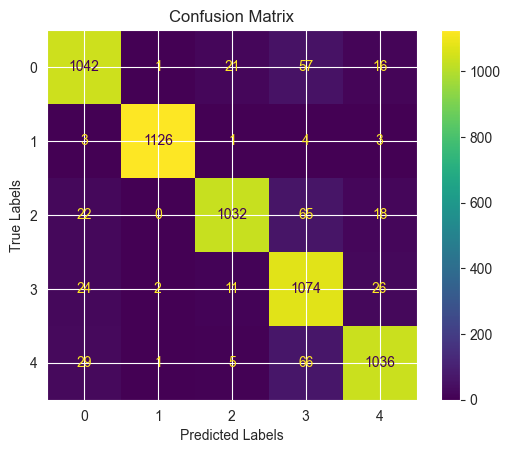

test_data report:
Acuuracy: 0.6071065989847716
F1_score: 0.5786163461078779


<Figure size 800x600 with 0 Axes>

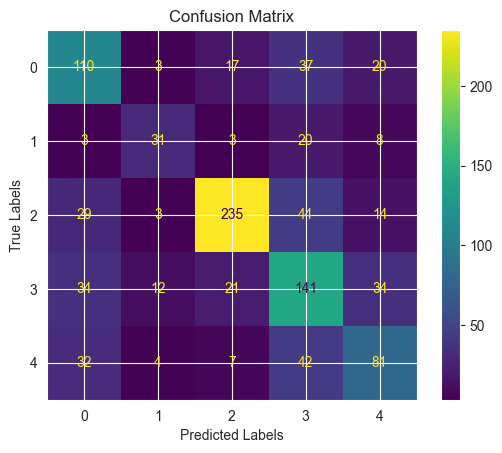

array([3., 0., 0., 0., 1., 3., 2., 0., 3., 3., 2., 2., 4., 0., 2., 3., 0.,
       4., 3., 3., 1., 4., 2., 0., 0., 2., 3., 2., 3., 0., 3., 0., 2., 4.,
       0., 0., 0., 2., 3., 2., 2., 0., 0., 4., 2., 0., 2., 0., 3., 0., 3.,
       2., 4., 3., 0., 0., 2., 0., 0., 0., 3., 1., 4., 3., 3., 1., 4., 2.,
       0., 0., 0., 2., 2., 4., 2., 3., 4., 2., 0., 2., 1., 1., 3., 2., 0.,
       3., 0., 2., 4., 1., 3., 2., 1., 2., 3., 4., 4., 3., 4., 2., 0., 0.,
       2., 0., 3., 4., 1., 2., 3., 0., 2., 3., 3., 0., 0., 3., 0., 2., 3.,
       4., 2., 3., 2., 2., 4., 4., 2., 0., 3., 2., 2., 3., 3., 0., 2., 0.,
       3., 2., 3., 2., 0., 4., 0., 3., 0., 3., 0., 0., 1., 2., 0., 3., 3.,
       1., 0., 0., 2., 3., 0., 2., 2., 1., 3., 4., 2., 1., 3., 2., 3., 3.,
       3., 0., 2., 3., 3., 3., 0., 4., 2., 0., 4., 3., 4., 0., 0., 3., 2.,
       3., 4., 3., 3., 2., 2., 0., 2., 2., 4., 4., 0., 3., 4., 4., 0., 4.,
       0., 3., 3., 3., 3., 3., 2., 3., 0., 2., 2., 3., 3., 2., 2., 0., 0.,
       2., 2., 3., 2., 2.

In [34]:
model_train_test_evaluating(X_train_resampled, y_train_resampled, vectorized_x_test, test_y, LGBMClassifier(), param_grids)

Light GBM is like Extra tree and, they are in the same level.

### XGBoost
This time its XGBoost turn to be checked.

In [35]:
param_grids = {
    'max_depth': [5, 10, 15], 'learning_rate': [0.1, 0.2, 0.3]
}
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assume you have your training and test data loaded into variables X_train and X_test

# Standardize the training and test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(vectorized_x_test)

num_components = 30

# Reduce the dimensionality of the training and test data
pca = PCA(n_components=num_components)
X_train_reduced = pca.fit_transform(X_train_scaled)
X_test_reduced = pca.transform(X_test_scaled)

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_y_encoded = label_encoder.fit_transform(train_y)
test_y_encoded = label_encoder.transform(test_y)
model_train_test_evaluating(X_train_reduced, y_train_resampled, X_test_reduced, test_y_encoded, XGBClassifier(), param_grids)

XGBoost doesn't give us any improvement and, it is same as Light GBM and Extra tree.

### Logistic Regression
Our work with tree based models is done. Now we will work with other classic models.
First of all we will start with logistic regression.

In [38]:
param_grids={
    'penalty': ['l1', 'l2'],
}

C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Lenovo\AppD

Cross validation results:
Best parameters between {'penalty': ['l1', 'l2']} are : {'penalty': 'l2'}
Best score with these parameters is : 0.7486
train data result:
Accuracy: 0.9083553210202286
F1_score: 0.9083529427094168


<Figure size 800x600 with 0 Axes>

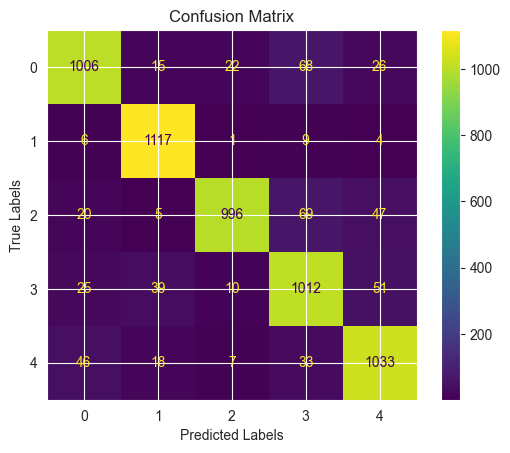

test_data report:
Acuuracy: 0.6203045685279188
F1_score: 0.5959236084851032


<Figure size 800x600 with 0 Axes>

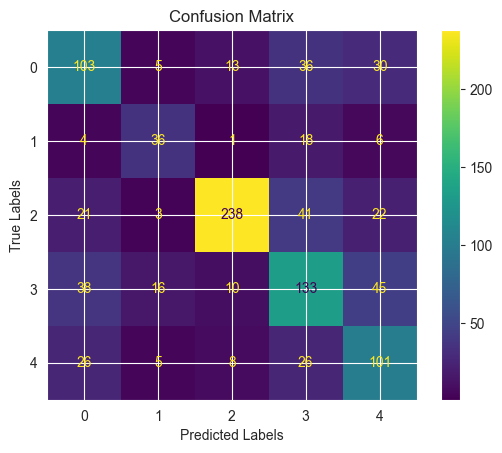

array([3., 0., 0., 3., 1., 3., 2., 0., 3., 3., 2., 2., 4., 0., 2., 3., 3.,
       0., 0., 1., 1., 4., 2., 2., 0., 2., 0., 2., 4., 3., 3., 0., 2., 0.,
       4., 3., 0., 2., 4., 2., 2., 4., 0., 4., 2., 0., 2., 0., 3., 2., 3.,
       2., 4., 3., 3., 3., 2., 0., 0., 0., 3., 1., 3., 0., 3., 1., 4., 2.,
       3., 0., 0., 2., 2., 4., 2., 0., 2., 2., 4., 4., 3., 1., 4., 2., 0.,
       3., 3., 2., 4., 1., 3., 4., 0., 0., 4., 2., 4., 4., 4., 2., 3., 2.,
       2., 4., 3., 4., 1., 3., 3., 0., 2., 3., 3., 0., 0., 2., 2., 2., 3.,
       4., 2., 3., 2., 2., 4., 4., 2., 0., 1., 2., 2., 3., 3., 0., 2., 4.,
       4., 2., 3., 4., 0., 4., 4., 3., 3., 0., 0., 0., 1., 2., 0., 4., 3.,
       1., 0., 0., 2., 3., 4., 3., 2., 1., 3., 4., 2., 1., 3., 2., 3., 2.,
       3., 0., 2., 3., 3., 3., 4., 0., 4., 3., 4., 3., 4., 0., 0., 3., 2.,
       3., 4., 0., 3., 2., 2., 0., 2., 2., 3., 4., 0., 3., 4., 4., 3., 4.,
       0., 3., 0., 3., 4., 0., 2., 3., 0., 2., 2., 3., 3., 2., 2., 0., 0.,
       2., 2., 3., 2., 2.

In [39]:
model_train_test_evaluating(X_train_resampled, y_train_resampled, vectorized_x_test, test_y, LogisticRegression(), param_grids)

LR performed better than the tree based models and have a two percent improvement in the test accuracy.

### KNN
After LR we will check the KNN.

In [40]:
param_grids = {
        'algorithm': ['auto', 'brute'],
}

Cross validation results:
Best parameters between {'algorithm': ['auto', 'brute']} are : {'algorithm': 'auto'}
Best score with these parameters is : 0.3745
train data result:
Accuracy: 0.5408970976253298
F1_score: 0.5075739517870315


<Figure size 800x600 with 0 Axes>

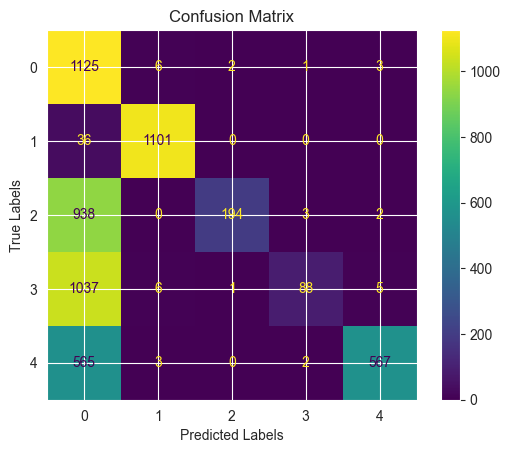

test_data report:
Acuuracy: 0.24060913705583756
F1_score: 0.16656604122321889


<Figure size 800x600 with 0 Axes>

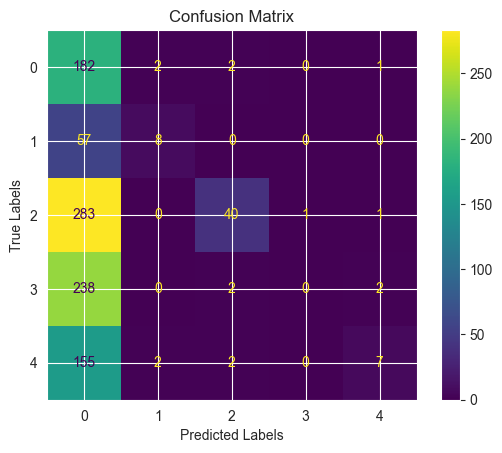

array([0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 0., 0.

In [41]:
from sklearn.neighbors import KNeighborsClassifier

model_train_test_evaluating(X_train_resampled, y_train_resampled, vectorized_x_test, test_y, KNeighborsClassifier(), param_grids)

KNN was awful and its performance is not acceptable.

### SVC
And we will check the support vector classifier as the last model.

In [42]:
param_grids = {
    'kernel': ['linear','poly', 'rbf']
}

Cross validation results:
Best parameters between {'kernel': ['linear', 'poly', 'rbf']} are : {'kernel': 'rbf'}
Best score with these parameters is : 0.7912
train data result:
Accuracy: 0.9910290237467019
F1_score: 0.9910314264001929


<Figure size 800x600 with 0 Axes>

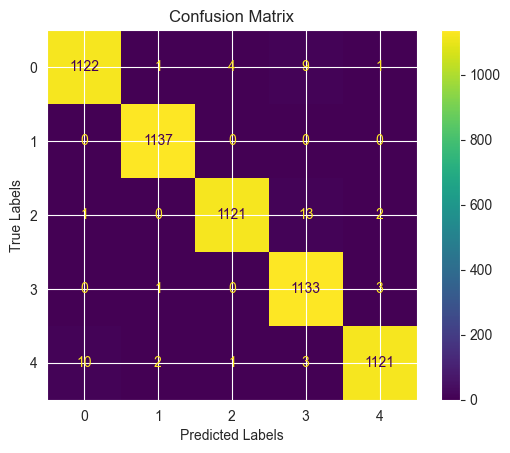

test_data report:
Acuuracy: 0.6243654822335025
F1_score: 0.5864721497137091


<Figure size 800x600 with 0 Axes>

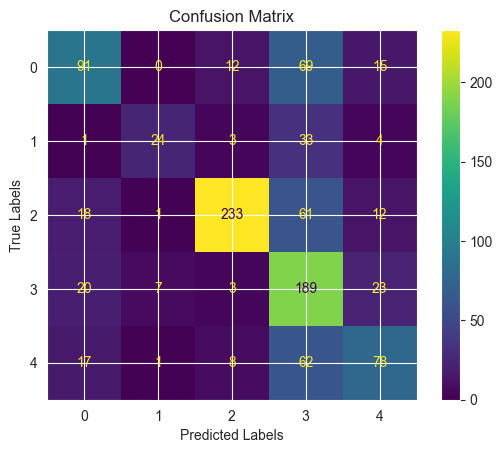

array([3., 3., 0., 3., 3., 3., 2., 0., 3., 3., 2., 2., 4., 0., 2., 3., 3.,
       4., 3., 3., 1., 4., 2., 3., 0., 2., 3., 2., 4., 3., 3., 0., 2., 0.,
       4., 3., 0., 2., 3., 2., 2., 0., 0., 0., 2., 0., 2., 0., 3., 2., 3.,
       2., 3., 3., 3., 3., 2., 0., 0., 0., 3., 3., 3., 3., 3., 1., 4., 2.,
       3., 3., 0., 2., 2., 4., 2., 3., 2., 2., 4., 3., 3., 3., 4., 2., 0.,
       3., 3., 2., 4., 3., 3., 3., 0., 0., 3., 2., 3., 4., 4., 2., 3., 3.,
       2., 4., 3., 3., 2., 3., 3., 0., 2., 3., 3., 3., 0., 2., 0., 2., 3.,
       4., 2., 2., 3., 2., 4., 4., 2., 3., 3., 2., 2., 3., 3., 0., 2., 4.,
       4., 2., 3., 4., 0., 0., 3., 3., 3., 3., 0., 0., 1., 2., 0., 3., 3.,
       1., 0., 0., 2., 3., 3., 3., 2., 1., 3., 4., 2., 1., 3., 2., 3., 3.,
       3., 0., 3., 3., 3., 3., 4., 0., 4., 3., 4., 3., 4., 0., 0., 3., 2.,
       3., 4., 3., 3., 2., 2., 3., 2., 2., 3., 4., 0., 3., 4., 4., 3., 4.,
       0., 3., 3., 3., 3., 3., 2., 3., 0., 2., 2., 3., 3., 2., 2., 0., 0.,
       2., 2., 3., 2., 2.

In [43]:
from sklearn.svm import SVC

model_train_test_evaluating(X_train_resampled, y_train_resampled, vectorized_x_test, test_y, SVC(), param_grids)

Support vector classifier is same as LR and perform better than tree based models.(also a little better than LR)

In [44]:
param_grids = {
    'solver': ['svd', 'lsqr'],
}

Cross validation results:
Best parameters between {'solver': ['svd', 'lsqr']} are : {'solver': 'svd'}
Best score with these parameters is : 0.6597
train data result:
Accuracy: 0.998768689533861
F1_score: 0.9987683017457843


<Figure size 800x600 with 0 Axes>

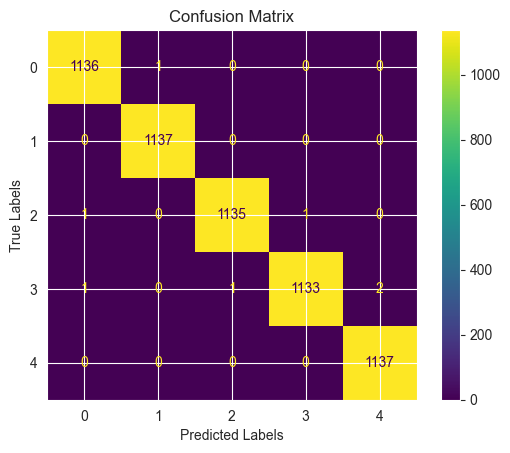

test_data report:
Acuuracy: 0.3604060913705584
F1_score: 0.3389684704622894


<Figure size 800x600 with 0 Axes>

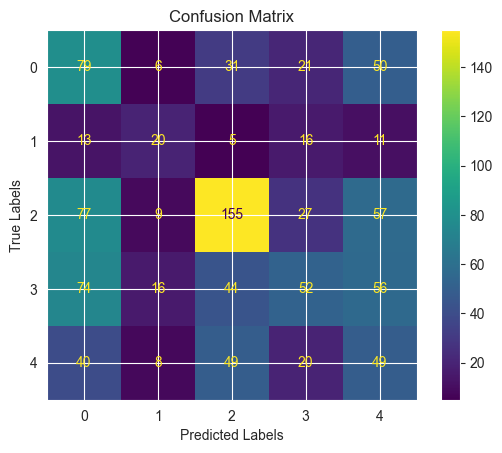

array([3., 0., 0., 3., 4., 2., 2., 0., 0., 4., 2., 4., 2., 2., 0., 0., 3.,
       0., 2., 0., 3., 2., 0., 0., 2., 2., 3., 2., 4., 0., 3., 4., 2., 4.,
       0., 0., 4., 0., 3., 2., 2., 0., 2., 0., 2., 0., 2., 4., 0., 0., 3.,
       2., 4., 2., 2., 3., 1., 0., 2., 3., 0., 2., 0., 4., 0., 2., 3., 2.,
       2., 0., 2., 4., 0., 2., 2., 0., 0., 0., 0., 2., 3., 0., 2., 2., 2.,
       0., 0., 2., 4., 4., 2., 4., 3., 0., 4., 4., 0., 4., 4., 2., 3., 2.,
       0., 0., 0., 4., 3., 4., 0., 0., 2., 3., 0., 4., 0., 2., 0., 2., 4.,
       0., 2., 2., 0., 2., 4., 4., 4., 0., 0., 2., 2., 3., 4., 2., 0., 4.,
       4., 2., 0., 4., 3., 0., 0., 3., 0., 1., 0., 0., 2., 0., 0., 1., 2.,
       3., 0., 0., 2., 3., 0., 0., 2., 1., 4., 2., 2., 1., 3., 2., 0., 1.,
       4., 4., 0., 2., 0., 4., 4., 0., 0., 4., 0., 0., 3., 0., 0., 0., 0.,
       3., 0., 4., 2., 0., 3., 4., 2., 2., 0., 4., 0., 3., 0., 2., 0., 3.,
       2., 0., 2., 0., 0., 4., 2., 0., 4., 4., 2., 4., 3., 3., 2., 0., 4.,
       2., 2., 0., 0., 2.

In [45]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

model_train_test_evaluating(X_train_resampled, y_train_resampled, vectorized_x_test, test_y, LinearDiscriminantAnalysis(), param_grids)

LDA is not acceptable and doesn't have a good performance.

The models which we trained include some tree-based models such as DecisionTreeClassifier, RandomForestClassifier, XGBoost, Light GBM and Extra tree. We also trained Support Vector Machines (SVM), Logistic Regression, KNN and LDA. It is obvious that the non-tree based models, such as SVM and Logistic Regression, have performed significantly better than the tree-based models. Among the tree-based models, the ensemble learning models, like RandomForest and XGBoost and Light GBM and Extra, have had better results compared to the single DecisionTreeClassifier model. Ensemble methods, such as Random Forest and XGBoost, combine multiple decision trees to create a more robust and accurate model, which helps to overcome the limitations of individual decision trees and improves the overall performance. The superior performance of the non-tree based models, such as SVM and Logistic Regression, suggests that the underlying data and problem at hand may be better suited for these types of algorithms compared to the tree-based models.

# Pipeline
In this part we will create a pipeline that by giving train test model and parameters, the pipeline will vectorize the data, normalize that and also by using CV find the pest parameters and evaluate the CV score and also evaluate the performance on test data.
There are some points that we understand from working on the training data:
1. Removing emojy is not effective.
2. Removing English words is not effective.
3. Handling the imbalance data is not effective.

So we won't repeat them in our pipeline.

In this section, we focused on training models with our dataset and evaluating their performance through 5-fold cross-validation. We constructed a function pipeline that streamlines the training and evaluation process. The pipeline takes in training and testing datasets, a machine learning model, and a set of parameters. It ensures that all the previously mentioned data preprocessing steps are systematically applied.

The core functionality of the pipeline involves performing a grid search for hyperparameter tuning. Grid search systematically works through multiple combinations of parameter values, cross-validating each combination to determine which provides the best performance. We implemented this using 5-fold cross-validation, where the training data is split into five subsets, and the model is trained on four subsets and validated on the fifth. This process is repeated five times, with each subset serving as the validation set.

By doing so, the model's performance is assessed comprehensively, which minimizes the risk of overfitting and ensures that the model generalizes well to unseen data. The pipeline identifies the best parameters by finding the combination that consistently provides the highest performance across all folds. Once these optimal parameters are determined, the best model is trained on the entire training dataset, and its performance is then evaluated on the test dataset.

In [46]:
def column_name_set(data):
    num_cols = data.shape[1]

    if num_cols == 2:
        data.columns = ['Sentence', 'Emotion']
    else:
        data.columns = ['Sentence']
        data['Emotion'] = None

    return data

Next two functions transform the persian numbers to latin and normalize five kind of 'ی' and give us just one kind. Also make all of english letters in lower case.

In [47]:
def normalize_persian(text):
    # Define a function to normalize Persian characters and numbers
    persian_digits = '۰۱۲۳۴۵۶۷۸۹٦'
    english_digits = '01234567896'
    yeh_characters = ['ی', 'ي', 'ے', 'ئ', 'ى']

    text = text.translate(str.maketrans(persian_digits, english_digits))
    for char in yeh_characters:
        text = text.replace(char, 'ی')

    return text

In [48]:
def preprocess_text(text):
    # Normalize Persian characters
    text = normalize_persian(text)

    # Convert to lowercase
    text = text.lower()

    # Add more preprocessing steps as needed

    return text

Next function split the data to features and target set.

In [49]:
def target_split(train_data, test_data):
    train_x = pd.DataFrame(train_data['Sentence'], columns=['Sentence'], index=train_data.index)
    train_y = train_data['Emotion']

    test_x = pd.DataFrame(test_data['Sentence'], columns=['Sentence'], index=test_data.index)
    test_y = test_data['Emotion']

    return train_x, train_y, test_x, test_y

By using next function we can vectorize our data.

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

def text_vectorizer(train_x, test_x):

    vectorizer = TfidfVectorizer()
    vector = vectorizer.fit_transform(train_x['Sentence'])
    vectorized_x_train = pd.DataFrame(vector.toarray(), columns=vectorizer.get_feature_names_out(), index=train_x.index)

    vector2 = vectorizer.transform(test_x['Sentence'])
    vectorized_x_test = pd.DataFrame(vector2.toarray(), columns=vectorizer.get_feature_names_out(), index=test_x.index)

    return vectorized_x_train, vectorized_x_test

In here we will define a function that by using train and test set and model and parameters for grid search, it will give us the best parameters by CV and also evaluate the performance of the by CV and also by test set and show us confusion matrix too.

In [51]:
from sklearn.metrics import f1_score, precision_score, accuracy_score, roc_curve, ConfusionMatrixDisplay, confusion_matrix, auc
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import matplotlib.pyplot as plt

def model_train_test_evaluating(x_train, y_train, x_test, y_test, model, param_grid):
    grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='f1_macro')
    grid_search.fit(x_train, y_train)
    classifier = grid_search.best_estimator_

    y_train_pred = classifier.predict(x_train)
    y_test_pred = classifier.predict(x_test)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    f1_train = f1_score(y_train, y_train_pred, average='macro')
    if not y_test.isnull().all():
        test_accuracy = accuracy_score(y_test, y_test_pred)
        f1_test = f1_score(y_test, y_test_pred, average='macro')

    print('Cross validation scores:')
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best score: {grid_search.best_score_:.4f}")

    print('train_data report:')
    print('Acuuracy: ', end='')
    print(train_accuracy)
    print('F1_score: ', end='')
    print(f1_train)

    cm = confusion_matrix(y_train, y_train_pred)
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    if not y_test.isnull().all():
        print('test_data report:')
        print('Acuuracy: ', end='')
        print(test_accuracy)
        print('F1_score: ', end='')
        print(f1_test)

        cm = confusion_matrix(y_test, y_test_pred)
        # Plot the confusion matrix
        plt.figure(figsize=(8, 6))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()

    return y_test_pred

And at last it is our pipe line that ease our work.

In [52]:
from sklearn.preprocessing import LabelEncoder

def pipline(train, test, model, param_grid):
    # Preproccessing

    # column name setting
    train = column_name_set(train)
    test = column_name_set(test)

    # changing ی in the text
    train['Sentence'] = train['Sentence'].apply(preprocess_text)
    test['Sentence'] = test['Sentence'].apply(preprocess_text)

    # normalize and tokenize the text
    train = text_normalizer(train)
    train = word_tokenizer(train)
    test = text_normalizer(test)
    test = word_tokenizer(test)

    # lemmatizing the text
    train = text_lemmatizer(train)
    test = text_lemmatizer(test)

    # target splitting
    train_x, train_y, test_x, test_y = target_split(train, test)

    # text vectorizing
    vectorized_x_train, vectorized_x_test = text_vectorizer(train_x, test_x)

    #encoding target
    label_encoder = LabelEncoder()
    train_y_encoded = label_encoder.fit_transform(train_y)
    if not test_y.isnull().all():
        test_y_encoded = pd.Series(label_encoder.transform(test_y))
    else:
        test_y_encoded = pd.Series(test_y)

    # Model training
    y_pred = model_train_test_evaluating(vectorized_x_train, train_y_encoded, vectorized_x_test, test_y_encoded, model, param_grid)
    y_pred = label_encoder.inverse_transform(y_pred)

    return y_pred

In here our pipeline development is finished and, it can do its work efficiently on the data.

In [53]:
tr_data = pd.read_csv('train_data.csv')
ts_data = pd.read_csv('3rdHW_test.csv')

Cross validation scores:
Best parameters: {'kernel': 'linear'}
Best score: 0.5543
train_data report:
Acuuracy: 0.789195775792039
F1_score: 0.7598023731611405


<Figure size 800x600 with 0 Axes>

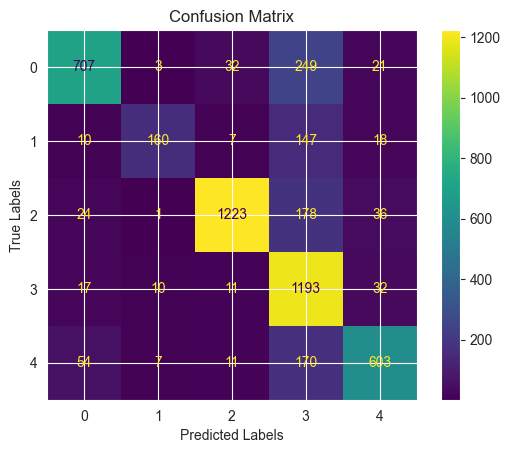

In [54]:
param_grid=[
    {'kernel': ['linear','poly', 'rbf']}
]

svm = SVC(C=0.5)
y_pred = pipline(tr_data, ts_data, svm, param_grid)

In [55]:
ts_data['Y'] = y_pred
final_data = ts_data.copy()

In [56]:
final_data

,Sentence,Emotion,Y
0,صعب روزید#روز ، بوالعجب کاشت#کار ، پریشان عالمی,None,OTHER
1,بسیار نرم و لطیف بوده و کیفیت بالایی داره .,None,HAPPY
2,اصلا رنگ با چیزی که تو عکس بود#است خیلی فرق داشت,None,ANGRY
3,خیلی زیبا و ب اندازه و با دقت طراحی‌شده,None,HAPPY
4,سبزی‌پلو با ماهی مال عید نوروزه ، امشب سوشی خو...,None,OTHER
...,...,...,...
543,سرخط خبرهای ۶ عصر ، پنجشنبه ۲۹ جدی ۱۴۰۱,None,OTHER
544,بوی عالی ماندگاری خوب خیلی خو امدش مرسی دیج,None,HAPPY
545,گاز که داشت#دار اینترنت هم روش ? #وطن,None,ANGRY
546,من چندتاشو برا مغازه گرفت#گیر باطریاشون کلا خر...,None,HAPPY


In [58]:
final_data = final_data.drop(['Emotion'], axis=1)
final_data = final_data.rename(columns={'Sentence': 'X'})
final_data

,X,Y
0,صعب روزید#روز ، بوالعجب کاشت#کار ، پریشان عالمی,OTHER
1,بسیار نرم و لطیف بوده و کیفیت بالایی داره .,HAPPY
2,اصلا رنگ با چیزی که تو عکس بود#است خیلی فرق داشت,ANGRY
3,خیلی زیبا و ب اندازه و با دقت طراحی‌شده,HAPPY
4,سبزی‌پلو با ماهی مال عید نوروزه ، امشب سوشی خو...,OTHER
...,...,...
543,سرخط خبرهای ۶ عصر ، پنجشنبه ۲۹ جدی ۱۴۰۱,OTHER
544,بوی عالی ماندگاری خوب خیلی خو امدش مرسی دیج,HAPPY
545,گاز که داشت#دار اینترنت هم روش ? #وطن,ANGRY
546,من چندتاشو برا مغازه گرفت#گیر باطریاشون کلا خر...,HAPPY


In [60]:
final_data.to_csv('test.csv', index=False)